In [3]:
import sys
sys.path.append('..')
from gamadhani.utils.utils import download_models, download_data
from gamadhani.src.dataset import SequenceDataset
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from gamadhani.utils.generate_utils import load_audio_fns
from gamadhani.utils.utils import get_device
import gin
from functools import partial
import torch
import gamadhani.utils.pitch_to_audio_utils as p2a
from tqdm import tqdm
import pdb

/home/mila/n/nithya.shikarpur/.conda/envs/test-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mila/n/nithya.shikarpur/.conda/envs/test-env/lib/python3.10/site-packages/x_transformers/x_transformers.py:445: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/mila/n/nithya.shikarpur/.conda/envs/test-env/lib/python3.10/site-packages/x_transformers/x_transformers.py:469: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


In [4]:
device = get_device()
_, _, audio_model_path, audio_qt_path = download_models('kmaneeshad/GaMaDHaNi', pitch_model_type="diffusion")
audio_model, audio_qt, audio_seq_len, invert_audio_fn = load_audio_fns(audio_path=audio_model_path,
    qt_path=audio_qt_path,
    config_path='/home/mila/n/nithya.shikarpur/GaMaDHaNi-dev/configs/pitch_to_audio_config.gin',
device=device)

Script is running on: GPU


/home/mila/n/nithya.shikarpur/GaMaDHaNi-dev/quantization-studies/../gamadhani/utils/generate_utils.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckp

In [5]:
n_samples = 1024
rand_inds = np.random.choice(np.arange(7174), n_samples)


In [6]:
gin.parse_config_file('/home/mila/n/nithya.shikarpur/GaMaDHaNi-dev/configs/pitch_to_audio_config_updated.gin')
db = '/home/mila/n/nithya.shikarpur/scratch/final-data-ismir/data/merged_data-finalest/cached-audio-pitch-16k/train'
db = SequenceDataset(db)

In [7]:
def visualize_layer_wise_weights(model):
    max_val = 0
    min_val = 0
    for i, (n,m) in enumerate(model.named_modules()):
        if isinstance(m, (torch.nn.Conv1d, torch.nn.Linear, torch.nn.ConvTranspose1d)):
            if len(m.weight.shape) == 3:
                print(n, m.weight.data.min(), m.weight.data.max())
                max_val = max(max_val, m.weight.data.max())
                min_val = min(min_val, m.weight.data.min())
                # plot weights
                plt.hist(m.weight.flatten().detach().cpu().numpy(), bins=100)
                if torch.isnan(m.weight).any():
                    print('nan')
    print('max', max_val, 'min', min_val)

In [8]:
def get_calib_data(db, time_range = (0, 1), group_size = 16):
    calib_data = []
    for i in rand_inds:
        spec, pitch, singer = db[i]
        time = torch.rand((1,))
        calib_data.append((spec, pitch, singer, time))
    
    spec_vals = torch.stack([x[0] for x in calib_data])
    spec_vals = torch.reshape(spec_vals, (spec_vals.shape[0]//group_size, group_size, spec_vals.shape[1], spec_vals.shape[2])).to(device)
    pitch_vals = torch.stack([x[1] for x in calib_data])
    pitch_vals = torch.reshape(pitch_vals, (pitch_vals.shape[0]//group_size, group_size, pitch_vals.shape[1])).to(device)
    singer_vals = torch.stack([x[2] for x in calib_data])
    singer_vals = torch.reshape(singer_vals, (singer_vals.shape[0]//group_size, group_size, singer_vals.shape[1])).to(device)
    time_vals = torch.stack([x[3] for x in calib_data])
    time_vals = torch.reshape(time_vals, (time_vals.shape[0]//group_size, group_size, time_vals.shape[1])).to(device)

    # Combine values for each batch
    grouped_batches = [
        (spec_vals[i], pitch_vals[i], singer_vals[i], time_vals[i]) 
        for i in range(spec_vals.shape[0])
    ]
    return grouped_batches

In [9]:
data = get_calib_data(db)

In [10]:
def process_input(batch):
    # pdb.set_trace()
    spec, pitch, singer, time = batch
    padded_x, padding = audio_model.pad_to(spec, audio_model.strides_prod)
    padded_f0, _ = audio_model.pad_to(pitch, audio_model.strides_prod)
    # padded_singer, _ = audio_model.pad_to(singer, audio_model.strides_prod)
    noise = torch.normal(0, 1, padded_x.shape).to(padded_x)
    # print(t.device, noise.device, x.device)
    x_t = time[:, None] * padded_x + (1 - time[:, None]) * noise
    return x_t, padded_f0

In [11]:
def get_calib_feat(model, tokenizer): # doesn't handle groups rn
    input_dict = dict()
    def stat_input_max_hook_conv(m, x, y, name):
        # pdb.set_trace()
        if isinstance(x, tuple):
            x = x[0]
        # input is of shape (batch_size, n_channels, n_frames), reshape so that channels is the last dimension
        x_max = x.transpose(1, 2).contiguous().view(-1, x.shape[1]).abs().max(dim=0).values.detach() # collecting the max value per input channel
        if name not in input_dict:
            input_dict[name] = x_max
        else:
            input_dict[name] = torch.max(input_dict[name], x_max)
    
    def stat_input_max_hook_linear(m, x, y, name):
        if isinstance(x, tuple):
            x = x[0]
        x_max = x.view(-1, x.shape[-1]).abs().max(dim=0).values.detach()
        if name not in input_dict:
            input_dict[name] = x_max
        else:
            input_dict[name] = torch.max(input_dict[name], x_max)

    hooks = []
    for name, m in model.named_modules():
        if isinstance(m, (torch.nn.Conv1d, torch.nn.ConvTranspose1d)): # add more layers here
            hooks.append(
                m.register_forward_hook(
                    partial(stat_input_max_hook_conv, name=name)))
            
        elif isinstance(m, torch.nn.Linear):
            hooks.append(
                m.register_forward_hook(
                    partial(stat_input_max_hook_linear, name=name)))

    print("Collecting activation scales...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    samples = get_calib_data(tokenizer)
    
    pbar = tqdm(samples)
    for input_vals in pbar:
        input_spec, f0 = process_input(input_vals)
        input_spec = input_spec.to(device)
        f0 = f0.to(device)
        time = input_vals[3].to(device).reshape(-1)
        singer = input_vals[2].to(device).int().reshape(-1)
        output = audio_model(x=input_spec, f0=f0, singer=singer, time=time, drop_tokens=False)

    for hook in hooks:
        hook.remove()
    return input_dict

In [12]:
input_feat = get_calib_feat(audio_model, db)

100%|██████████| 64/64 [00:02<00:00, 31.12it/s]


# Calibrate weights

In [28]:
audio_model.device

device(type='cuda', index=0)

In [60]:
import copy
# reloads the model 
del audio_model
torch.cuda.empty_cache()

audio_model, audio_qt, audio_seq_len, invert_audio_fn = load_audio_fns(audio_path=audio_model_path,
    qt_path=audio_qt_path,
    config_path='/home/mila/n/nithya.shikarpur/GaMaDHaNi-dev/configs/pitch_to_audio_config.gin',
device=device)

orig_model = copy.deepcopy(audio_model)

In [61]:
ratio = 0.5


In [62]:
def quantize_per_tensor(x, bits=6, min_val=None, max_val=None):
    if min_val is None:
        min_val = x.min()
    if max_val is None:
        max_val = x.max()
    targets = torch.linspace(min_val, max_val, 2**bits).to(x.device)
    differences = torch.abs(x.unsqueeze(-1) - targets)
    nearest_indices = torch.argmin(differences, dim=-1)
    rounded_values = targets[nearest_indices]
    return rounded_values

initial_projection
downsample_layers.0.process_layer.convs.0.conv
downsample_layers.0.process_layer.convs.1.conv
downsample_layers.0.process_layer.convs.2.conv
downsample_layers.0.process_layer.convs.3.conv
downsample_layers.1.input_layers.1
downsample_layers.1.process_layer.convs.0.conv
downsample_layers.1.process_layer.convs.1.conv
downsample_layers.1.process_layer.convs.2.conv
downsample_layers.1.process_layer.convs.3.conv
downsample_layers.2.input_layers.1
downsample_layers.2.process_layer.convs.0.conv
downsample_layers.2.process_layer.convs.1.conv
downsample_layers.2.process_layer.convs.2.conv
downsample_layers.2.process_layer.convs.3.conv
f0_conv_layers.0
f0_conv_layers.1
f0_conv_layers.2
upsample_layers.0.input_layers.1
upsample_layers.0.process_layer.convs.0.conv
upsample_layers.0.process_layer.convs.1.conv
upsample_layers.0.process_layer.convs.2.conv
upsample_layers.0.process_layer.convs.3.conv
upsample_layers.1.input_layers.1
upsample_layers.1.process_layer.convs.0.conv
upsam

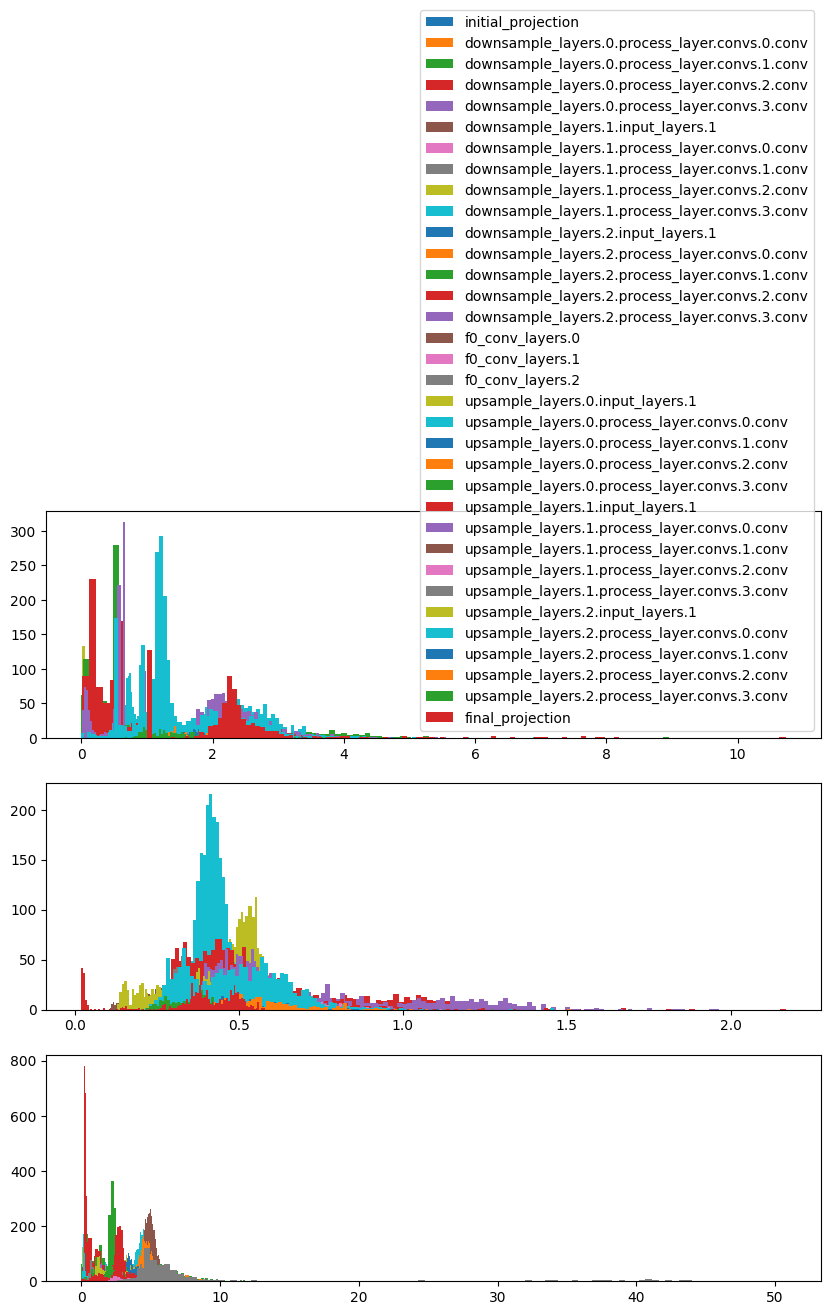

In [63]:
fig, axs = plt.subplots(3, figsize=(10, 10))
for n, m in audio_model.named_modules():
    if n in input_feat.keys():
        activations = input_feat[n]
        scales = activations**ratio
        if isinstance(m, (torch.nn.Conv1d)):
            # if n == 'final_projection':
            #     continue
            print(n)
            transpose_weight = torch.transpose(m.weight, 1, 2) # to keep the last dimension as the input channel dimension
            max_weight_per_channel = (transpose_weight.reshape(-1, transpose_weight.shape[-1]).abs().max(dim=0)).values**(1-ratio)
            axs[0].hist(scales.detach().cpu().numpy(), bins=100, label=n)
            scales = scales / max_weight_per_channel
        
            axs[1].hist(max_weight_per_channel.detach().cpu().numpy(), bins=100)
            axs[2].hist(scales.detach().cpu().numpy(), bins=100)
            scaled_weights = m.weight.data.mul_(scales[None, :, None])
            for channel in range(scaled_weights.shape[1]):
                scaled_weights[:, channel, :] = quantize_per_tensor(scaled_weights[:, channel, :])
            m.weight.data = scaled_weights.div_(scales[None, :, None])
        
        elif isinstance(m, torch.nn.ConvTranspose1d):
            print(n)
            axs[0].hist(scales.detach().cpu().numpy(), bins=100, label=n)
            max_weight_per_channel = (m.weight.reshape(m.weight.shape[0], -1).abs().max(dim=1).values)**(1-ratio)
            scales = scales / max_weight_per_channel
            axs[1].hist(max_weight_per_channel.detach().cpu().numpy(), bins=100)
            axs[2].hist(scales.detach().cpu().numpy(), bins=100)
            scaled_weights = m.weight.data.mul_(scales[:, None, None])
            for channel in range(scaled_weights.shape[0]):
                scaled_weights[channel, :, :] = quantize_per_tensor(scaled_weights[channel, :, :])
            m.weight.data = scaled_weights.div_(scales[:, None, None])
        elif isinstance(m, torch.nn.Linear):
            max_weight_per_channel = (m.weight.abs().max(dim=0).values)**(1-ratio)
            scales = scales / max_weight_per_channel
            # scales = torch.clamp(scales, max=10)
            plt.hist(scales.detach().cpu().numpy(), bins=100)
            scaled_weights = m.weight.data.mul_(scales[None, :])
            for channel in range(scaled_weights.shape[1]):
                scaled_weights[:, channel] = quantize_per_tensor(scaled_weights[:, channel])
            m.weight.data = scaled_weights.div_(scales[None, :])
        axs[0].legend()
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data = quantize_per_tensor(m.bias.data)

initial_projection tensor(-0.4015, device='cuda:0') tensor(0.3346, device='cuda:0')
downsample_layers.0.process_layer.convs.0.conv tensor(-0.8535, device='cuda:0') tensor(0.5303, device='cuda:0')
downsample_layers.0.process_layer.convs.1.conv tensor(-1.7335, device='cuda:0') tensor(1.9491, device='cuda:0')
downsample_layers.0.process_layer.convs.2.conv tensor(-4.6983, device='cuda:0') tensor(2.0865, device='cuda:0')
downsample_layers.0.process_layer.convs.3.conv tensor(-2.5106, device='cuda:0') tensor(3.8532, device='cuda:0')
downsample_layers.1.input_layers.1 tensor(-0.6139, device='cuda:0') tensor(1.2067, device='cuda:0')
downsample_layers.1.process_layer.convs.0.conv tensor(-1.2429, device='cuda:0') tensor(0.5676, device='cuda:0')
downsample_layers.1.process_layer.convs.1.conv tensor(-1.0087, device='cuda:0') tensor(1.6260, device='cuda:0')
downsample_layers.1.process_layer.convs.2.conv tensor(-0.3116, device='cuda:0') tensor(0.5574, device='cuda:0')
downsample_layers.1.process_laye

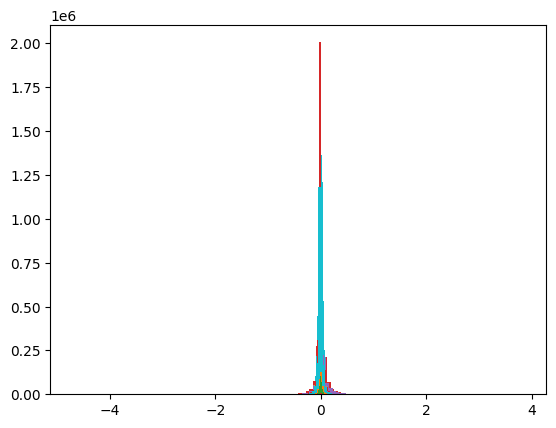

In [64]:
visualize_layer_wise_weights(audio_model)

In [65]:
# preprocess pitch to feed it as conditioning to the spectrogram generator

# parse pitch config
gin.parse_config_file('/home/mila/n/nithya.shikarpur/GaMaDHaNi-dev/configs/diffusion_pitch_config.gin')
Task_ = gin.get_configurable('src.dataset.Task')
task_obj = Task_()
pitch_task_fn = partial(task_obj.read_)
invert_pitch_task_fn = partial(task_obj.invert_)

In [66]:
primes = np.load('/home/mila/n/nithya.shikarpur/scratch/final-data-ismir/data/merged_data-finalest/listening_study_primes.npz', allow_pickle=True)

In [67]:
processed_pitch_val = [pitch_task_fn(**{"inputs": {"pitch": {"data": val[0][:2400]}}})['sampled_sequence'] for val in primes['concatenated_array']]
processed_pitch_val = torch.Tensor(np.stack(processed_pitch_val)).reshape(len(processed_pitch_val), 1, processed_pitch_val[0].shape[0])
interpolated_pitch = p2a.interpolate_pitch(pitch=processed_pitch_val, audio_seq_len=audio_seq_len)    # interpolate pitch values to match the audio model's input size
interpolated_pitch = torch.nan_to_num(interpolated_pitch, nan=196)  # replace nan values with silent token
interpolated_pitch = interpolated_pitch.squeeze(1) # to match input size by removing the extra dimension
f0 = interpolated_pitch.float()
audio_model = audio_model.to(device)
print(f0.shape)

torch.Size([16, 750])


In [68]:
singer_tensor = torch.tensor(np.repeat([3], repeats=f0.shape[0])).to(audio_model.device)

In [73]:
samples, _, singers, _ = audio_model.sample_cfg(f0.shape[0], f0=f0, num_steps=10, singer=singer_tensor, strength=3, invert_audio_fn=invert_audio_fn)

In [74]:
audio = invert_audio_fn(samples)

100%|██████████| 200/200 [00:00<00:00, 756.85it/s]


In [75]:
audio

tensor([[-2.1011,  0.7534,  4.7228,  ...,  2.1390,  0.6932, -4.7719],
        [-4.6090, -1.9744,  4.7549,  ...,  1.0646,  0.9834, -4.1682],
        [-1.7760,  0.0342, -0.0276,  ..., -1.3335,  1.3926, -1.1578],
        ...,
        [-4.0598, -1.0362,  0.4572,  ...,  2.9119,  0.6970, -0.4199],
        [ 0.4837,  1.7338,  2.3405,  ..., -1.2833,  3.2123,  0.3953],
        [ 4.7857, -1.3100,  2.2592,  ...,  2.6396,  0.1669, -0.4897]],
       device='cuda:0')

In [76]:
ipd.Audio(audio[1].detach().cpu().numpy(), rate=16000)

In [77]:
torch.save(audio_model.state_dict(), '/home/mila/n/nithya.shikarpur/GaMaDHaNi-dev/eval/examples/activations-aware-quantized_per_channel_6_bit.pt')

initial_projection tensor(-0.4015, device='cuda:0') tensor(0.3346, device='cuda:0')
downsample_layers.0.process_layer.convs.0.conv tensor(-0.8535, device='cuda:0') tensor(0.5303, device='cuda:0')
downsample_layers.0.process_layer.convs.1.conv tensor(-1.7335, device='cuda:0') tensor(1.9491, device='cuda:0')
downsample_layers.0.process_layer.convs.2.conv tensor(-4.6983, device='cuda:0') tensor(2.0865, device='cuda:0')
downsample_layers.0.process_layer.convs.3.conv tensor(-2.5106, device='cuda:0') tensor(3.8532, device='cuda:0')
downsample_layers.1.input_layers.1 tensor(-0.6139, device='cuda:0') tensor(1.2067, device='cuda:0')
downsample_layers.1.process_layer.convs.0.conv tensor(-1.2429, device='cuda:0') tensor(0.5676, device='cuda:0')
downsample_layers.1.process_layer.convs.1.conv tensor(-1.0087, device='cuda:0') tensor(1.6260, device='cuda:0')
downsample_layers.1.process_layer.convs.2.conv tensor(-0.3116, device='cuda:0') tensor(0.5574, device='cuda:0')
downsample_layers.1.process_laye

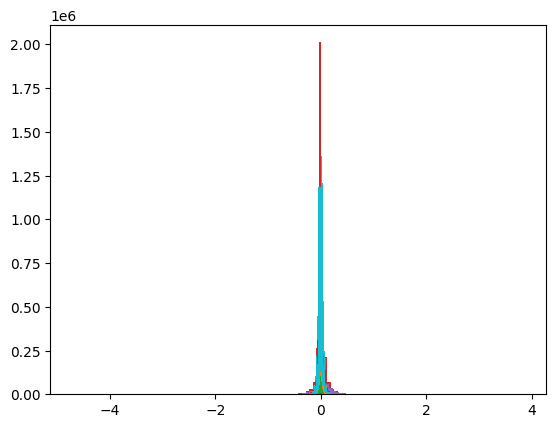

In [42]:
visualize_layer_wise_weights(orig_model)

In [56]:
torch.max(orig_model.initial_projection.weight.data - audio_model.initial_projection.weight.data)

tensor(0.9119, device='cuda:0')